 # Finetune a GET Model on PBMC 10k Multiome


 This tutorial demonstrates how to train a GET model to predict expression in ATAC-seq peaks using motif information. We'll cover:

 1. Loading and configuring the model

 2. Finetune from a pretrained expression prediction GET model

 3. Perform various analysis using `gcell` package



 ## Setup

 First, let's import the necessary modules and set up our configuration.
 
 Note:
 If you run from a Mac, make sure you use the jupyter notebook rather than the VSCode interactive python editor as the later seems to have issue with multiple workers.
 If you run from Linux, both should work fine.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from gcell.cell.celltype import GETHydraCellType
from gcell.utils.causal_lib import get_subnet, plot_comm, preprocess_net

from get_model.config.config import load_config
from get_model.run_region import run_zarr as run


Importing from timm.models.layers is deprecated, please import via timm.layers


 ## Finetune



 We'll start by loading a predefined configuration and customizing it for our needs.

 The base configuration is in `get_model/config/finetune_tutorial_pbmc.yaml`

In [2]:
if not Path('./checkpoint-best.pth').exists():
    s3_checkpoint_url = "s3://2023-get-xf2217/get_demo/checkpoints/regulatory_inference_checkpoint_fetal_adult/finetune_fetal_adult_leaveout_astrocyte/checkpoint-best.pth"
    ! aws s3 cp $s3_checkpoint_url ./checkpoint-best.pth --no-sign-request

> Note: In the paper, we mainly used binary ATAC signal trained model for motif interpretation analysis. As it's hard to say whether there are mutual causal relationship between transcription and accessibility. If accessibility is added to the model, potentially it will absorb some TF's effect to itself, thereby making the interpretation more difficult. However, if the goal is to represent the cell states as precisely as possible and use the model for other downstream tasks (e.g. enhancer target prediction), adding the accessibility signal is probably better.

In [5]:
celltype_for_modeling = [
    'memory_b',
    'cd14_mono',
    'gdt',
    'cd8_tem_1',
    'naive_b',
    'mait',
    'intermediate_b',
    'cd4_naive',
    'cd8_tem_2',
    'cd8_naive',
    'cd4_tem',
    'cd4_tcm',
    'cd16_mono',
    'nk',
    'cdc',
    'treg']
cfg = load_config('finetune_tutorial_pbmc') # load the predefined finetune tutorial config
cfg.stage = 'fit'
cfg.run.run_name = 'training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac'
cfg.dataset.quantitative_atac = False # We use binary ATAC signal for motif interpretation analysis
cfg.dataset.zarr_path = "./pbmc10k_multiome.zarr" # set the path to the data zarr file we just processed
cfg.dataset.celltypes = ','.join(celltype_for_modeling) # the celltypes you want to finetune
cfg.finetune.checkpoint = "./checkpoint-best.pth" # set the path to the pretrained checkpoint we want to finetune from
cfg.dataset.leave_out_celltypes = 'cd4_tcm' # set the celltypes you want to leave out
cfg.machine.num_devices=1 # use 0 for cpu training; >=1 for gpu training
cfg.machine.batch_size=8 # batch size for training; check `nvidia-smi` to see the available GPU memory
print(f"output path: {cfg.machine.output_dir}/{cfg.run.project_name}/{cfg.run.run_name}")
print(f"training for {cfg.training.epochs} epochs")

output path: /home/xf2217/output/finetune_pbmc10k_multiome/training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac
training for 50 epochs


Now we can start the finetuning

Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


wandb: Currently logged in as: xf2217 (get-v3). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


  7%|▋         | 1/15 [00:00<00:02,  5.19it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 20%|██        | 3/15 [00:00<00:02,  5.41it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 33%|███▎      | 5/15 [00:00<00:01,  5.67it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 40%|████      | 6/15 [00:01<00:01,  6.12it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 47%|████▋     | 7/15 [00:01<00:01,  5.62it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 60%|██████    | 9/15 [00:01<00:01,  5.45it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 73%|███████▎  | 11/15 [00:02<00:00,  5.27it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 87%|████████▋ | 13/15 [00:02<00:00,  5.03it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


100%|██████████| 15/15 [00:02<00:00,  5.26it/s]


Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


  0%|          | 0/1 [00:00<?, ?it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

NameError: name 'exit' is not defined

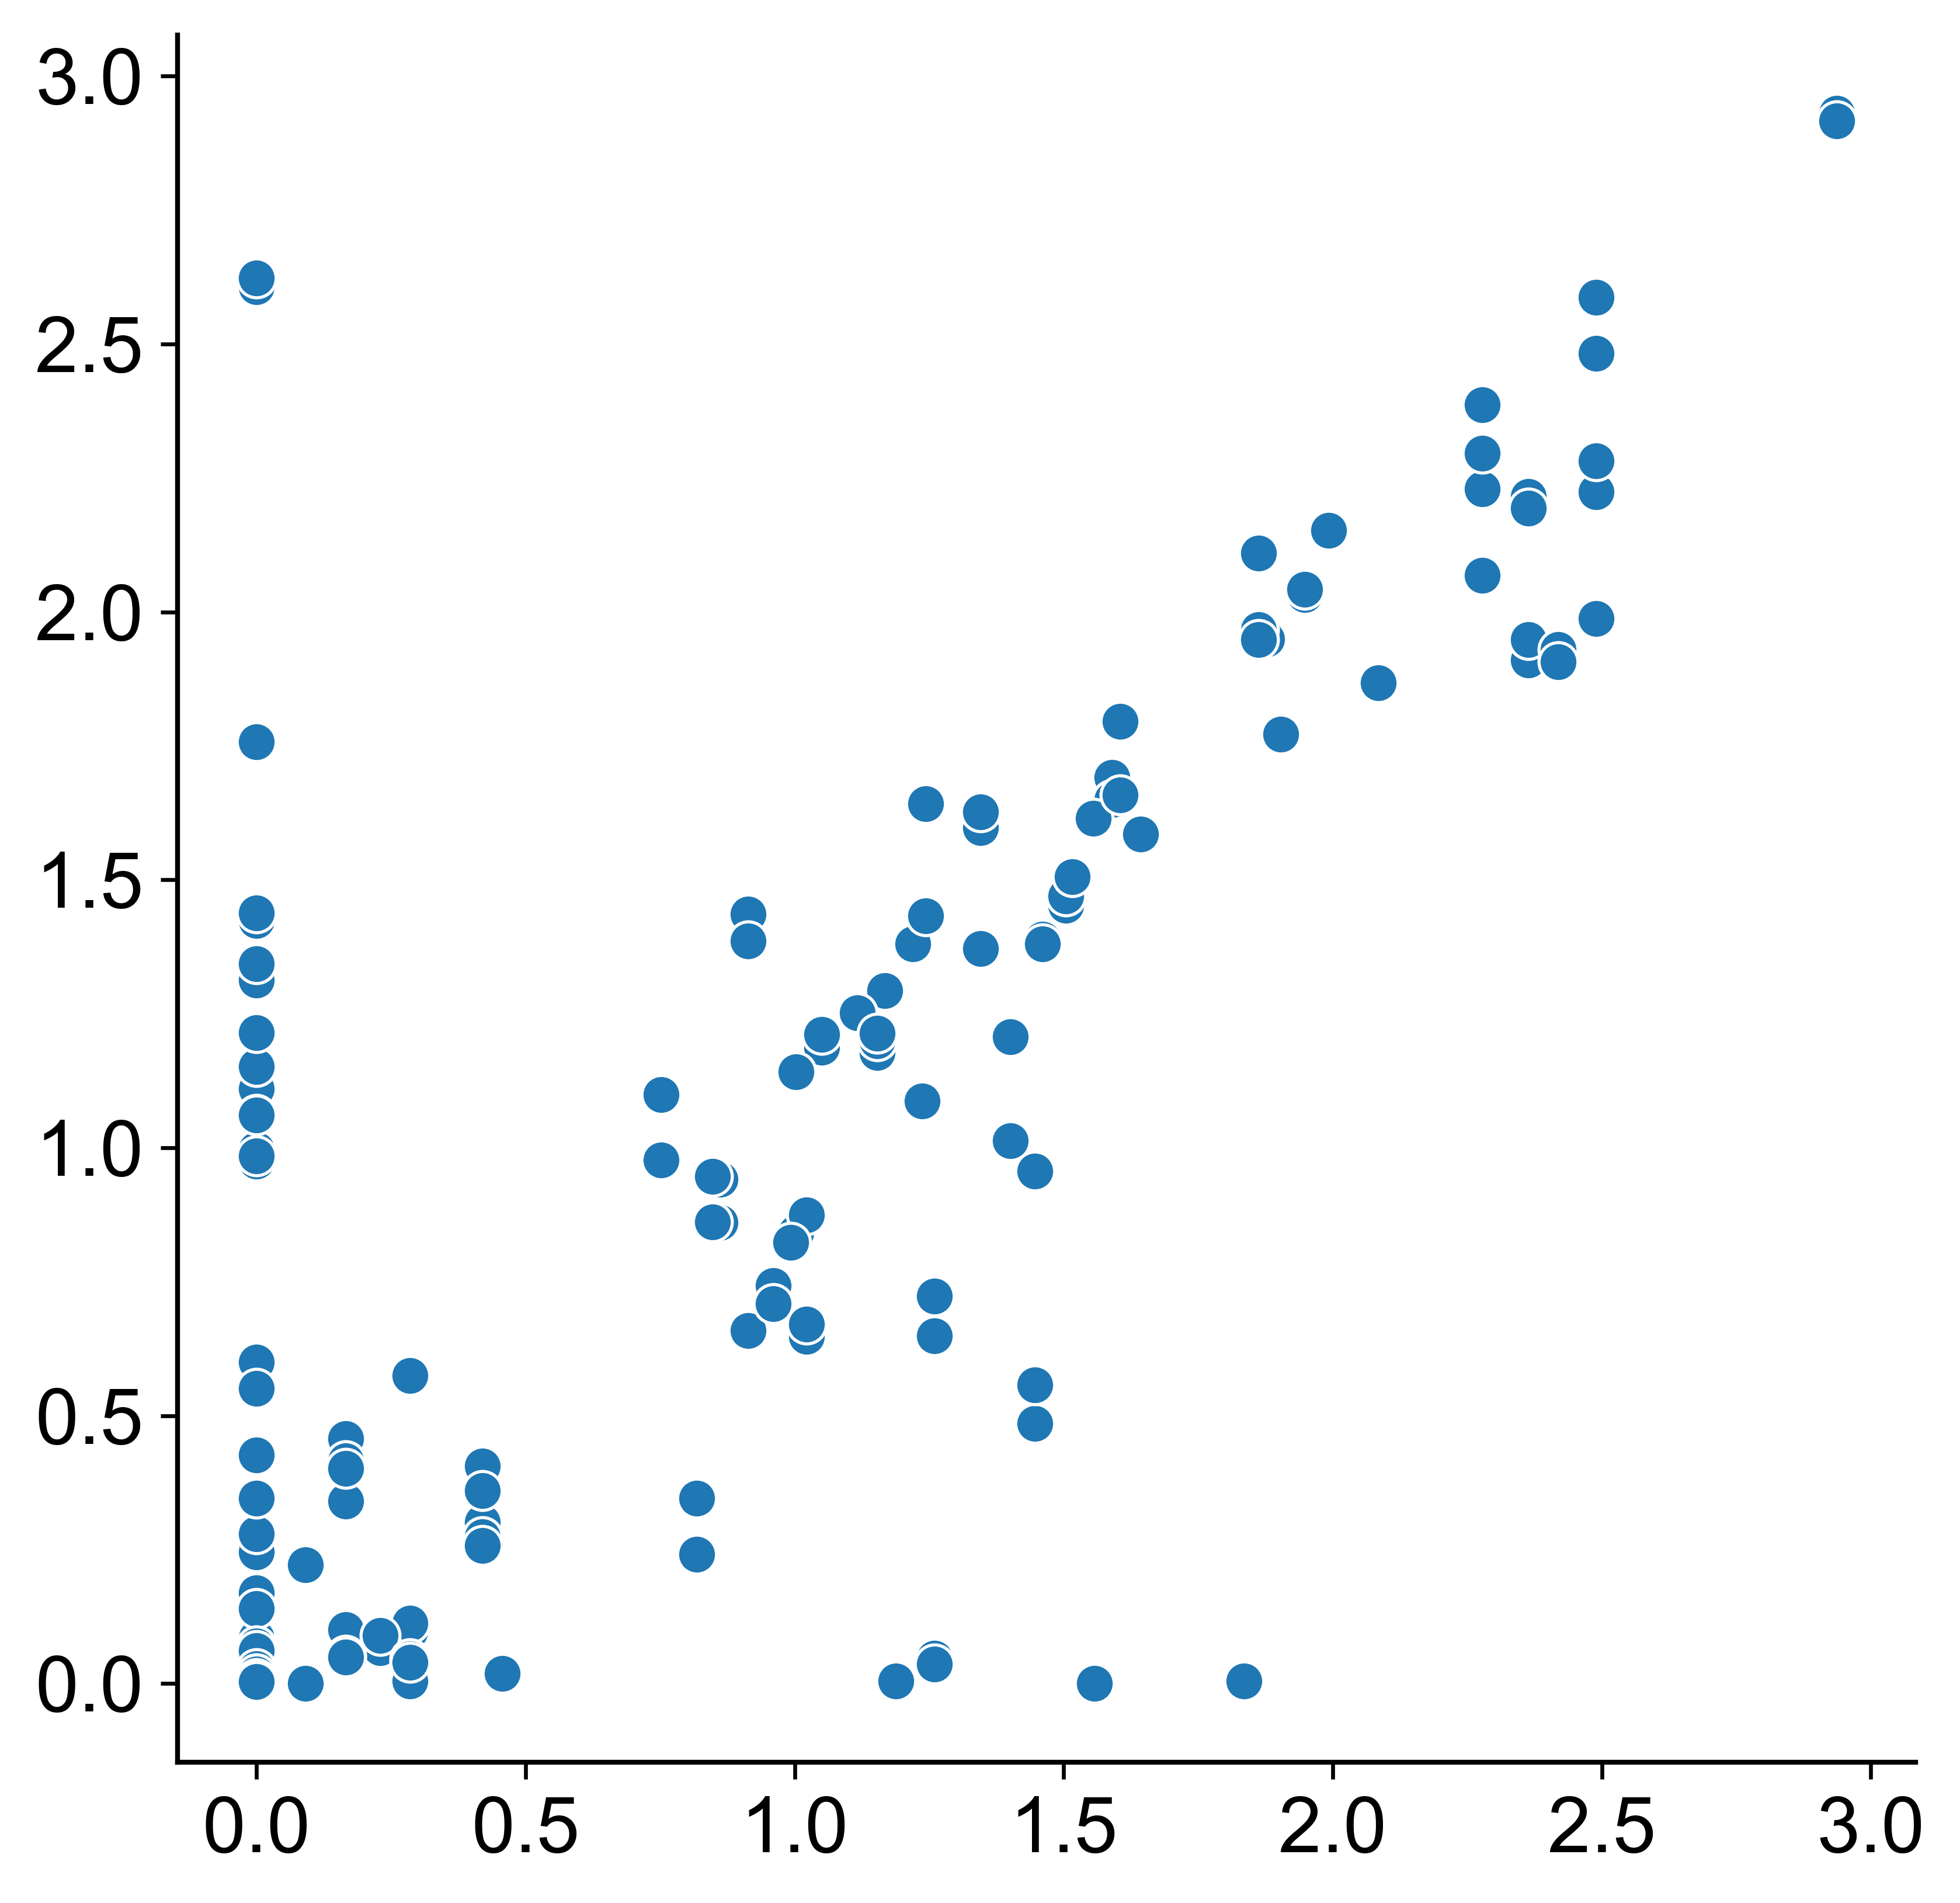

In [6]:
trainer = run(cfg) # run the finetuning, takes around 2 hours on one RTX 3090
print("checkpoint path:", trainer.checkpoint_callback.best_model_path)

# Interpretation

After finetuning, we can use the checkpoint to predict expression of all accessible genes and generate jacobian matrix of (peak x motif) for every predicted genes. 
To start, we need to collect the checkpoint we produced and switch to `predict` stage. Here, let's focus on CD4 Naive cell and we need to set `cfg.leave_out_celltypes` to `cd4_naive` for the model to predict gene expression in this cell type.

In [8]:
use_checkpoint = '/home/xf2217/output/finetune_pbmc10k_multiome/training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac/checkpoints/best.ckpt' # trainer.checkpoint_callback.best_model_path # or specify a previously saved checkpoint
cfg.stage = 'predict'
cfg.finetune.resume_ckpt = use_checkpoint
# in predict stage, leave out the celltype you want to interpret
cfg.run.use_wandb=False # disable wandb logging when predicting
cfg.task.layer_names = [] # set to empty list to disable intermediate layer interpretation
cfg.task.gene_list = None # set to None to predict all genes; otherwise you can specify a list of genes as 'MYC,SOX10,SOX2,RET', only genes with promoter open will be used
# loop through all celltypes and run the predict stage
cfg.run.run_name='interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac'

for celltype in ['cd4_tcm', 'cd8_naive']:
    cfg.dataset.leave_out_celltypes = celltype
    trainer = run(cfg)





Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


100%|██████████| 1/1 [00:05<00:00,  5.35s/it]
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:362: The dirpath has changed from '/home/xf2217/output/finetune_pbmc10k_multiome/training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac/checkpoints' to '/home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/loops/prediction_loop.py:257: predict returned None if it was on purpose, ignore this warning...


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac/cd4_tcm.zarr


an object_codec is only needed for object arrays


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac/cd4_tcm.zarr


Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


  0%|          | 0/1 [00:00<?, ?it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


100%|██████████| 1/1 [00:05<00:00,  5.37s/it]
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:362: The dirpath has changed from '/home/xf2217/output/finetune_pbmc10k_multiome/training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac/checkpoints' to '/home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/lightning/pytorch/loops/prediction_loop.py:257: predict returned None if it was on purpose, ignore this warning...


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac/cd8_naive.zarr


an object_codec is only needed for object arrays


Saving batch of results to /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac/cd8_naive.zarr


As you can see, the results is now saved to `finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split/cd4_naive.zarr`. Now we can use the `GETHydraCellType` class from `gcell` to load it.

## Load interpretation result as `GETHydraCellType`

In [11]:
# get the celltype object based on the configuration
celltype = 'cd4_tcm'
cfg = load_config('finetune_tutorial_pbmc')
cfg.run.run_name='interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac'
cfg.dataset.leave_out_celltypes = celltype
hydra_celltype = GETHydraCellType.from_config(cfg, celltype=celltype) # if you ran the predict stage multiple times on different celltypes, you can specify the celltype you want to load here


In [12]:
hydra_celltype

GETHydraCelltype: cd4_tcm
        Zarr path: /home/xf2217/output/finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac/cd4_tcm.zarr
        Number of regions per sample: 200
        Number of features: 283
        Number of genes: 15202
        Number of peaks: 3040400
        

We can plot the predicted and observed expression to see whether there is any issue.

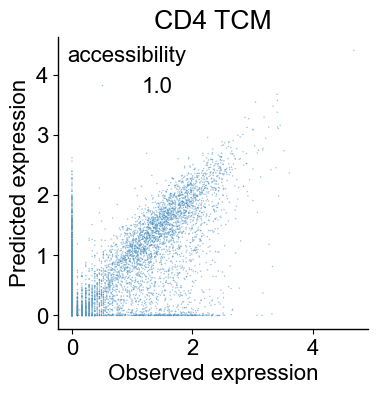

In [18]:
# set dpi to 100 
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(data = hydra_celltype.gene_annot[['gene_name', 'obs', 'pred', 'accessibility']].groupby('gene_name').max(), x='obs', y = 'pred', hue='accessibility', s=1, alpha=0.5, ax=ax)
ax.set_title('CD4 TCM')
ax.set_xlabel('Observed expression')
ax.set_ylabel('Predicted expression')
ax.set_aspect('equal')
plt.show()


# Case study on CD4 TCM cells
Let's have a look at CD4 TCM RNA-seq to find some marker genes of it:
marker_genes = ['INPP4B', 'ANK3', 'ITGB1', 'CDC14A', 'CD8A', CD4'
]

In [33]:
# load the scanpy object
import scanpy as sc

rna_filtered = sc.read('rna.h5ad')
# get marker genes for 'CD4 Naive'
sc.tl.rank_genes_groups(rna_filtered, 'cell_type', method='wilcoxon', rankby_abs=False)
sc.pl.rank_genes_groups(rna_filtered, n_genes=20, sharey=False)


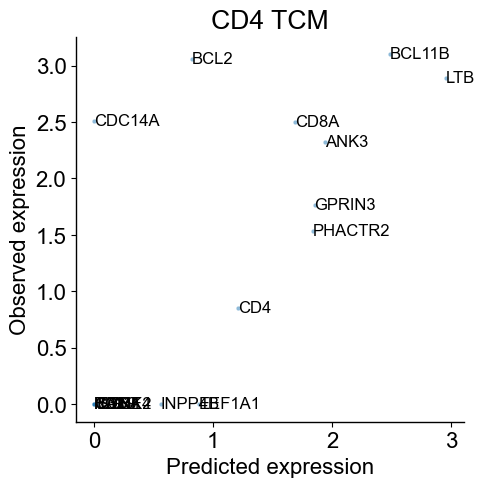

In [86]:
marker_genes = ['INPP4B', 'ANK3', 'ITGB1', 'CDC14A', 'CD8A', 'CD4', 'IL32', 'LTB', 'SYNE2', 'IL7R', 'TM6SF4X', 
                'EEF1A1', 'GPRIN3', 'RORA', 'TRAC', 'BCL11B', 'TM6SF10', 'CAMK4', 'CD69', 'PHACTR2', 'BCL2', 'ARID5B']
df = hydra_celltype.gene_annot.query('gene_name.isin(@marker_genes)')[['gene_name', 'pred', 'obs']].groupby('gene_name').max().reset_index()
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data = df, x='pred', y='obs', s=10, alpha=0.5, ax=ax)
# add text to the plot
for i, row in df.iterrows():
    ax.text(row['pred'], row['obs'], row['gene_name'], fontsize=12, verticalalignment='center')
ax.set_title('CD4 TCM')
ax.set_xlabel('Predicted expression')
ax.set_ylabel('Observed expression')
plt.show()


Compare CD4 TCM with CD8 Naive

In [23]:
# get the celltype object based on the configuration
celltype = 'cd4_tcm'
cfg.dataset.leave_out_celltypes = celltype
gene_annot_dict = {}
# cd14_mono.zarr  cd4_naive.zarr  cd8_naive.zarr  cd8_tem_1.zarr  cd8_tem_2.zarr  csv_logs  gdt.zarr  intermediate_b.zarr  mait.zarr  memory_b.zarr  naive_b.zarr
for celltype in ['cd4_tcm', 'cd8_naive']:
    try:
        cfg.dataset.leave_out_celltypes = celltype
        hydra_celltype = GETHydraCellType.from_config(cfg, celltype=celltype) # if you ran the predict stage multiple times on different celltypes, you can specify the celltype you want to load here
        gene_annot_dict[celltype] = hydra_celltype.gene_annot
    except Exception as e:
        print(f"Error loading {celltype}: {e}")
        continue

In [67]:
# for each gene, collect the predicted and observed expression from all celltypes
# get a common intersected gene list first
import numpy as np
import pandas as pd

common_gene_list = set(gene_annot_dict['cd4_tcm'].index)
for celltype in ['cd4_tcm', 'cd8_naive']:
    try:
        common_gene_list = common_gene_list.intersection(set(gene_annot_dict[celltype].index))
    except Exception as e:
        print(f"Error loading {celltype}: {e}")
        continue
# then collect the expression
for celltype in ['cd4_tcm', 'cd8_naive']:
    try:
        gene_annot_dict[celltype] = gene_annot_dict[celltype].loc[np.array(common_gene_list)]
    except Exception as e:
        print(f"Error loading {celltype}: {e}")
        continue
# make a dataframe with the expression in each celltype for all genes



In [87]:
merged = pd.merge(gene_annot_dict['cd4_tcm'], gene_annot_dict['cd8_naive'], on=['gene_name', 'Start'], suffixes=('_cd4_tcm', '_cd8_naive'))


Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


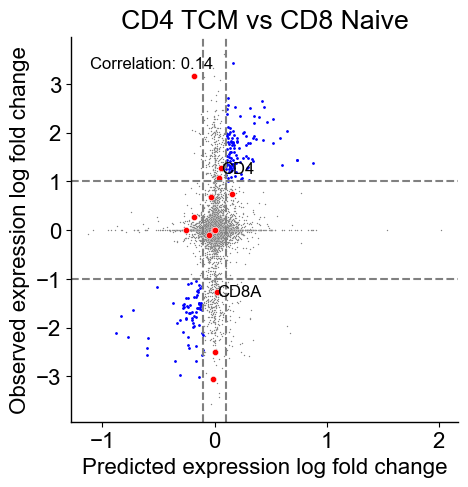

In [98]:
merged = merged[['gene_name', 'pred_cd4_tcm', 'pred_cd8_naive', 'obs_cd4_tcm', 'obs_cd8_naive']].groupby('gene_name').max().reset_index()
# merged = merged.query('obs_cd4_tcm>0 or obs_cd8_naive>0')
merged['pred_lfc'] = merged['pred_cd4_tcm'] - merged['pred_cd8_naive']
merged['obs_lfc'] = merged['obs_cd4_tcm'] - merged['obs_cd8_naive']
merged['marker_genes'] = merged['gene_name'].isin(marker_genes)
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data = merged.query('~marker_genes'), x='pred_lfc', y='obs_lfc', s=1, alpha=1, color='gray', ax=ax)
sns.scatterplot(data = merged.query('marker_genes'), x='pred_lfc', y='obs_lfc', s=20, alpha=1, color='red', ax=ax)
ax.set_title('CD4 TCM vs CD8 Naive')
ax.set_xlabel('Predicted expression log fold change')
ax.set_ylabel('Observed expression log fold change')
# add correlation coefficient
ax.text(0.05, 0.95, f'Correlation: {merged["pred_lfc"].corr(merged["obs_lfc"]):.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
#add vline and hline at 1 and -1
ax.axhline(y=1, color='gray', linestyle='--')
ax.axhline(y=-1, color='gray', linestyle='--')
ax.axvline(x=0.1, color='gray', linestyle='--')
ax.axvline(x=-0.1, color='gray', linestyle='--')
# highlight point outside the range
ax.scatter(merged.query('pred_lfc>0.1 & obs_lfc>1')['pred_lfc'], merged.query('pred_lfc>0.1 & obs_lfc>1')['obs_lfc'], color='blue', s=1, alpha=1)
ax.scatter(merged.query('pred_lfc<-0.1 & obs_lfc<-1')['pred_lfc'], merged.query('pred_lfc<-0.1 & obs_lfc<-1')['obs_lfc'], color='blue', s=1, alpha=1)
# add [CD8A and CD4] to the plot 
for gene in ['CD8A', 'CD4']:
    ax.text(merged.query(f'gene_name=="{gene}"')['pred_lfc'], merged.query(f'gene_name=="{gene}"')['obs_lfc'], gene, fontsize=12, verticalalignment='center')
plt.show()


In [89]:
merged.sort_values('pred_lfc', ascending=False).head(20)

gene_name  pred_cd4_tcm  pred_cd8_naive  obs_cd4_tcm  obs_cd8_naive  \
4180     HAUS6      2.389471        0.370693     0.000000       0.000000   
8821      RHOA      1.920063        0.380775     0.000000       0.000000   
581       ARAF      1.159761        0.254908     0.000000       0.000000   
124      ACTA2      1.669125        0.787250     1.371845       0.000000   
9029      RPRM      0.881223        0.002384     0.000000       0.000000   
2718   DNAJC25      0.885487        0.016766     0.000000       0.000000   
5013    KCTD12      0.901394        0.037512     0.000000       0.000000   
3373     FANCL      1.025976        0.190669     0.000000       0.000000   
7201      NTN4      1.262597        0.490405     0.334848       0.598826   
496      ANXA1      1.749994        0.978315     2.712635       1.947554   
8004     PNPT1      0.920182        0.152316     0.000000       0.000000   
9051      RPS6      0.847273        0.107347     0.000000       0.000000   
6300    METTL6      1.138475        0.400705     1.446499       0.000000   
4258    HEXIM1      1.142121        0.405530     1.431814       0.000000   
5935    LRRIQ3      1.351115        0.633679     0.000000       0.000000   
1073      BRD2      1.980193        1.289467     2.061970       1.958843   
6242     MED23      0.797149        0.117062     0.000000       0.000000   
1970    CLASP2      1.659331        0.982977     0.000000       2.098787   
8050    POLR3K      1.101153        0.439803     0.000000       0.000000   
8905    RNF138      1.227367        0.583112     0.000000       1.972798   

      pred_lfc   obs_lfc  marker_genes  
4180  2.018778  0.000000         False  
8821  1.539287  0.000000         False  
581   0.904853  0.000000         False  
124   0.881875  1.371845         False  
9029  0.878839  0.000000         False  
2718  0.868721  0.000000         False  
5013  0.863883  0.000000         False  
3373  0.835307  0.000000         False  
7201  0.772192 -0.263977         False  
496   0.771679  0.765081         False  
8004  0.767866  0.000000         False  
9051  0.739926  0.000000         False  
6300  0.737770  1.446499         False  
4258  0.736592  1.431814         False  
5935  0.717436  0.000000         False  
1073  0.690727  0.103127         False  
6242  0.680087  0.000000         False  
1970  0.676354 -2.098787         False  
8050  0.661350  0.000000         False  
8905  0.644255 -1.972798         False

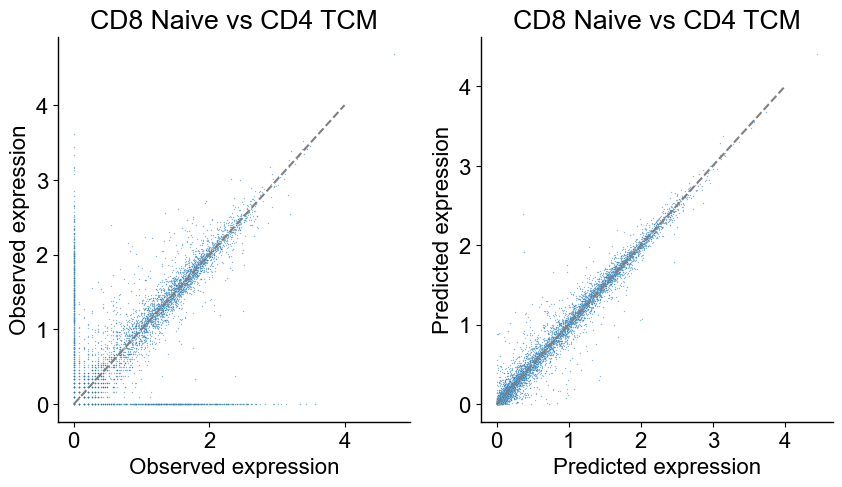

In [94]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
sns.scatterplot(data=merged, x='obs_cd8_naive', y='obs_cd4_tcm', ax=ax[0], s=1, alpha=0.5)
ax[0].set_title('CD8 Naive vs CD4 TCM')
ax[0].set_xlabel('Observed expression')
ax[0].set_ylabel('Observed expression')
sns.scatterplot(data=merged, x='pred_cd8_naive', y='pred_cd4_tcm', ax=ax[1], s=1, alpha=0.5)
ax[1].set_title('CD8 Naive vs CD4 TCM')
ax[1].set_xlabel('Predicted expression')
ax[1].set_ylabel('Predicted expression')
# add x=y to both
ax[0].plot([0, 4], [0, 4], color='gray', linestyle='--')
ax[1].plot([0, 4], [0, 4], color='gray', linestyle='--')
plt.show()




